# DETECION DE PLAGIAT 

In [122]:
import pandas as pd
import numpy as np

import re
import string
import nltk

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')


import joblib

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))  # français ici


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laurine\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Chargement des donnees

In [142]:
def load_plagiarism_data(path):
    df = pd.read_csv(path)
    df = df.dropna(subset=['texte_plagie', 'texte_original'])
   # print("\nAperçu des données :")
    print("\nRépartition des classes (non plagiat vs plagiat) :")
    print(df.head())
    df = df[df['target'].isin([0, 1])]
    df = df.sample(frac=0.1,random_state=42)
    print(df['target'].value_counts())
    return df

# 2. Nettoyage et pretraitement des donnees 

In [144]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>+", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = re.sub(r"\s+", " ", text)
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

def preprocess_plagiarism_data(df):
    df['clean_text_original'] = df['texte_original'].apply(clean_text)
    df['clean_text_soumis'] = df['texte_plagie'].apply(clean_text)
    df['text_diff'] = df['clean_text_original'] + " [SEP] " + df['clean_text_soumis']
    return df


# 3. Analyse exploratoire

In [148]:

def plot_class_distribution(df, label_column='target'):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=label_column, data=df, order=df[label_column].value_counts().index)
    plt.title("Distribution des classes")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# 4. Vectorisation 

In [150]:

def vectorize_text(method, X_train, X_test):
    if method == 'tfidf':
        vectorizer = TfidfVectorizer()
    else:
        vectorizer = CountVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    return X_train_vec, X_test_vec, vectorizer


# 5. Entrainement 

In [152]:

def train_models(X_train, y_train):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Random Forest": RandomForestClassifier(n_estimators=100),
        "SVM": SVC()
    }
    trained = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained[name] = model
    return trained


# 6. Evaluation

In [156]:

def evaluate_models(models, X_test, y_test):
    for name, model in models.items():
        y_pred = model.predict(X_test)
        print(f"\n\n===== {name} =====")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_ if hasattr(model, 'classes_') else np.unique(y_test))
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Matrice de confusion - {name}")
        plt.show()


# 7. Pipeline Complet

In [162]:


def full_pipeline_plagiarism(csv_path, method='tfidf'):
    df = load_plagiarism_data(csv_path)
    df = preprocess_plagiarism_data(df)
    
    plot_class_distribution(df, label_column='target')

    X = df['text_diff']
    y = df['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_vec, X_test_vec, vectorizer = vectorize_text(method, X_train, X_test)
    models = train_models(X_train_vec, y_train)
    evaluate_models(models, X_test_vec, y_test)
    joblib.dump(models["Random Forest"], "plagiat_best_nodel_RF.pkl")
    joblib.dump(vectorizer, "vectorizer_plagiat.pkl")
    print(" Modèle et vectoriseur sauvegardés !")


# 8. Execution


Répartition des classes (non plagiat vs plagiat) :
                                      texte_original  \
0  A person on a horse jumps over a broken down a...   
1  A person on a horse jumps over a broken down a...   
2             Children smiling and waving at camera.   
3             Children smiling and waving at camera.   
4  A boy is jumping on skateboard in the middle o...   

                                    texte_plagie  target  
0  A person is at a diner, ordering an omelette.       0  
1              A person is outdoors, on a horse.       1  
2                     There are children present       1  
3                          The kids are frowning       0  
4              The boy skates down the sidewalk.       0  
target
1    18545
0    18192
Name: count, dtype: int64


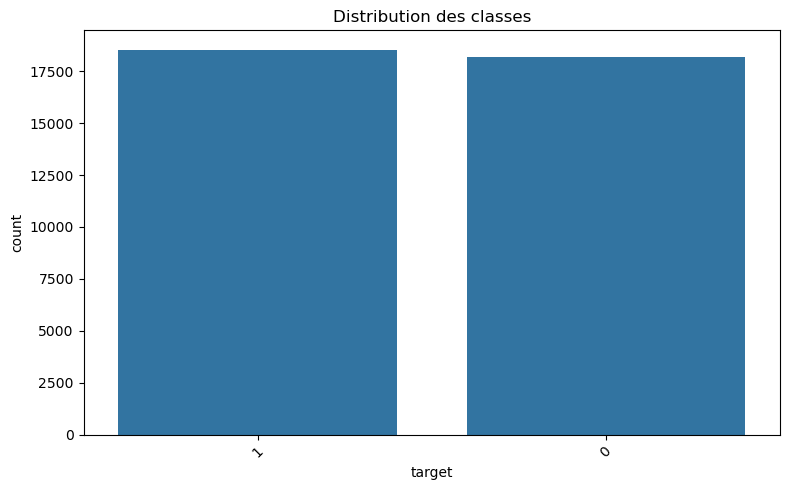



===== Logistic Regression =====
Accuracy: 0.6472509526401742
              precision    recall  f1-score   support

           0       0.66      0.62      0.64      3710
           1       0.64      0.67      0.65      3638

    accuracy                           0.65      7348
   macro avg       0.65      0.65      0.65      7348
weighted avg       0.65      0.65      0.65      7348



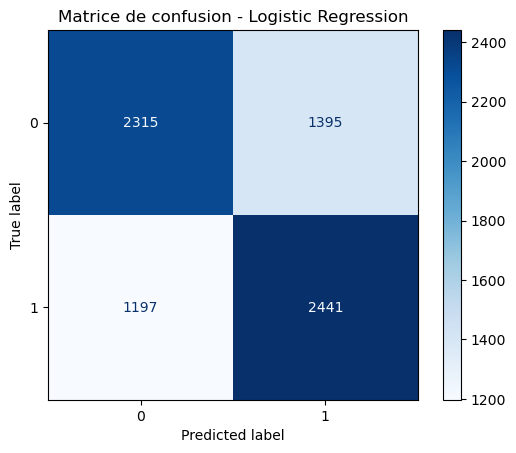



===== Random Forest =====
Accuracy: 0.6913445835601524
              precision    recall  f1-score   support

           0       0.74      0.59      0.66      3710
           1       0.66      0.79      0.72      3638

    accuracy                           0.69      7348
   macro avg       0.70      0.69      0.69      7348
weighted avg       0.70      0.69      0.69      7348



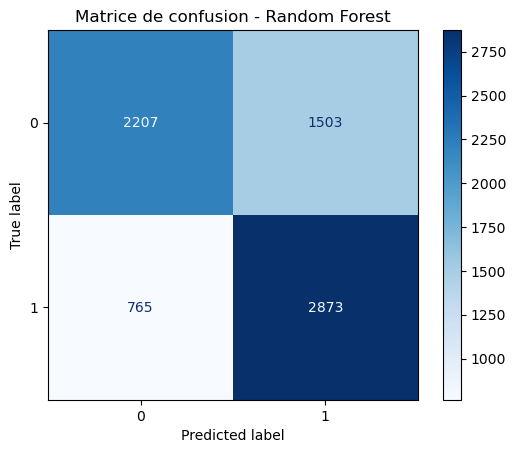



===== SVM =====
Accuracy: 0.6619488296135003
              precision    recall  f1-score   support

           0       0.68      0.63      0.65      3710
           1       0.65      0.70      0.67      3638

    accuracy                           0.66      7348
   macro avg       0.66      0.66      0.66      7348
weighted avg       0.66      0.66      0.66      7348



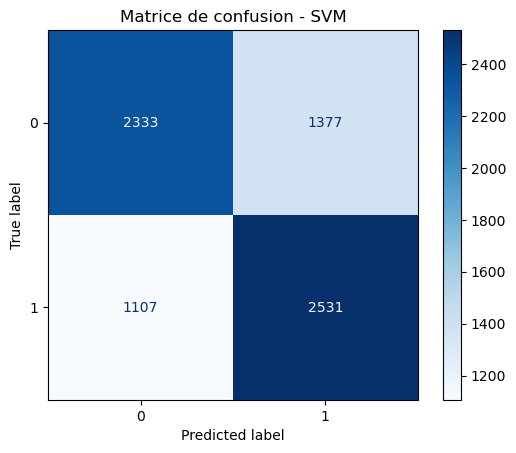

 Modèle et vectoriseur sauvegardés !


In [164]:
if __name__ == "__main__":
    csv_path = "dataset_plagiat.csv"
    full_pipeline_plagiarism(csv_path, method='tfidf')
   
